# Assignment 4. Modeling

### Due: March 4th (Thursday) 11:59 pm

## Introduction

In this assignment, we ask you to create a classifier for detecting spam. Please populate this Jupyter notebook with your code and embeded results (outputs, figures, etc) and submit it on Canvas.


### Useful libraries for this assignment

- sklearn


### Q1 (50 points)
You have been provided a spam dataset (SPAM.csv). Each line in the dataset corresponds to one message and has a label of either "ham" or "spam". In this assignment, you are experimenting with different features and models to create the best spam detector possible.  

Load the data into a dataframe. Divide the data into a train/test set with the ratio 85/15. Finally, use sklearn to run the following experiments.

Train and evaluate (using 5-fold cross validation) the following models:

(1) Logistic Regression 
<br>
(2) Random Forest 
<br>
(3) K Nearest Neighbours with n_neighbors = 3 
<br>
(4)  K Nearest Neighbours with n_neighbors = 5

and the following preprocessing:
<br>
(1) with lowercasing <br> (2) without lowercasing

and the following features: 
<br>
(1) unigrams <br>(2) unigrams and bigrams <br>(3) unigrams and bigrams and trigrams <br>
(4) tfidf unigrams <br>(5) tfidf  unigrams and bigrams <br>(6) tfidf  unigrams and bigrams and trigrams 

So that's 4 models x 2 possible prepreocessing x 6 possible features = 48 models

Create a dataframe where each row is one of the models and 3 columns showing the default f1 (default parameters), the weighted f1, and the accuracy of the model. Please use a human readable name for each model (don't call them model1, model2, etc.)

Which model has best weighted f1?

Take the best model and run it on the test dataset. Report the weighted f1 and plot the precision recall curve.

HINT 1: You should convert the "spam" category to 1 and the "ham" category to 0, sklearn models can only work with numbers.

HINT 2: Cross-validation should be run using the training data only.

In [1]:
# write your code here

import pandas as pd
from nltk import ngrams
from itertools import product
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, accuracy_score
data = pd.read_csv("SPAM.csv")
data['Category'] = data['Category'].replace({'ham':0, 'spam':1})
ori_X_train, ori_X_test, ori_y_train, ori_y_test = train_test_split(data['Message'],data['Category'],test_size=0.25)

ml_models = ["LR", "RF", "KNN3", "KNN5"]
case_options = ["lower", "non-lower"]
feature_options = ["uni", "uni-bi", "uni-bi-tri", "tf-idf-uni", "tf-idf-uni-bi", "tf-idf-uni-bi-tri"]



def get_ml_model(model_name):
    if model_name == "LR":
        return LogisticRegression()
    elif model_name == "RF":
        return RandomForestClassifier()
    elif model_name == "KNN3":
        return KNeighborsClassifier(n_neighbors=3)
    elif model_name == "KNN5":
        return KNeighborsClassifier(n_neighbors=5)
    else:
        raise("model not defined")

def get_preprocessed_case(option, X):
    if option == "lower":
        return X.apply(lambda x: x.lower())
    elif option == "non-lower":
        return X
    else:
        raise("case option not defined")


def get_nlp_feature(option, X_train, X_test):
    if option.startswith('tf'):
        vec_func = TfidfVectorizer
    else:
        vec_func = CountVectorizer

    if "uni-bi-tri" in option:
        ngram_range = (1, 3)
    elif "uni-bi" in option:
        ngram_range = (1, 2)
    elif "uni" in option:
        ngram_range = (1, 1)
    else:
        raise("wrong nlp feature option")

    CVector=vec_func(ngram_range=ngram_range, min_df=5)
    vect=CVector.fit(X_train)
    X_train_vectorized=vect.transform(X_train)
    X_test_vectorized=vect.transform(X_test)
    return X_train_vectorized, X_test_vectorized

validation_scores_data = [[0, 0, 0] for _ in range(48)]
model_idx = 0
validation_scores_model_name = []

for model_name, case_option, feature_option in product(ml_models, case_options, feature_options):
    X_train = get_preprocessed_case(case_option, ori_X_train)
    X_test = get_preprocessed_case(case_option, ori_X_test)
    X_train, X_test = get_nlp_feature(feature_option, X_train, X_test)
    # model.fit(X_train, ori_y_train)
    kf = KFold(n_splits=5)
    model_score = [0, 0, 0]
    for train_idx, vali_idx in kf.split(X_train):
        model = get_ml_model(model_name)
        X_train_train, X_train_vali = X_train[train_idx], X_train[vali_idx]
        y_train_train, y_train_vali = ori_y_train.iloc[train_idx], ori_y_train.iloc[vali_idx]
        model.fit(X_train_train, y_train_train)
        y_vali_pred = model.predict(X_train_vali)
        model_score[0] += f1_score(y_train_vali, y_vali_pred)
        model_score[1] += f1_score(y_train_vali, y_vali_pred, average="weighted")
        model_score[2] += accuracy_score(y_train_vali, y_vali_pred)
    model_score = [i/5 for i in model_score]
    validation_scores_data[model_idx] = model_score
    model_idx += 1
    validation_scores_model_name.append(",".join([model_name, case_option, feature_option]))


validation_scores_df = pd.DataFrame(data=validation_scores_data)
validation_scores_df.index = validation_scores_model_name
validation_scores_df.columns = ['f1', 'f1_weighted', 'accuracy']
validation_scores_df

,f1,f1_weighted,accuracy
"LR,lower,uni",0.931934,0.982311,0.982771
"LR,lower,uni-bi",0.930052,0.981797,0.982292
"LR,lower,uni-bi-tri",0.930052,0.981797,0.982292
"LR,lower,tf-idf-uni",0.853892,0.963682,0.965782
"LR,lower,tf-idf-uni-bi",0.851829,0.963307,0.965543
"LR,lower,tf-idf-uni-bi-tri",0.841198,0.960843,0.963389
"LR,non-lower,uni",0.931934,0.982311,0.982771
"LR,non-lower,uni-bi",0.930052,0.981797,0.982292
"LR,non-lower,uni-bi-tri",0.930052,0.981797,0.982292
"LR,non-lower,tf-idf-uni",0.853892,0.963682,0.965782


Best settings are: LR,lower,uni-bi, with averaged 5-fold f1_weighted on validation = 0.981615

weighted f1 score on test set is: 0.9804183900197779


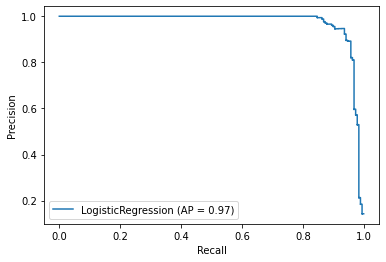

In [3]:
from sklearn.metrics import plot_precision_recall_curve
X_train = get_preprocessed_case("lower", ori_X_train)
X_test = get_preprocessed_case("lower", ori_X_test)
X_train, X_test = get_nlp_feature("uni-bi", X_train, X_test)
model = get_ml_model("LR")
model.fit(X_train, ori_y_train)
y_test_pred = model.predict(X_test)
print(f"weighted f1 score on test set is: {f1_score(ori_y_test, y_test_pred, average='weighted')}")
plot_precision_recall_curve(model, X_test, ori_y_test)

### BONUS (20 points)
Find a combination of preprocessing, features, and models that outperforms the best model above (using weighted f1 as a metric)

weighted f1 score on test set is: 0.9831601705728652


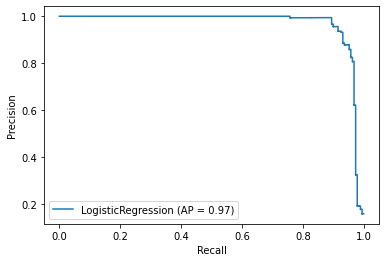

In [18]:
from nltk.corpus import stopwords
from nltk import PorterStemmer, word_tokenize

porter = PorterStemmer()
sws = stopwords.words('english')

def get_preprocessed_stem(x):
    cleaned_text = []
    words = word_tokenize(x)

    for w in words:
        if w.isalnum():
            w = w.lower()
            if w not in sws:
                cleaned_text.append(porter.stem(w))
        else:
            cleaned_text.append(w)
    return ' '.join(cleaned_text)

X_train = ori_X_train.apply(get_preprocessed_stem)
X_test = ori_X_test.apply(get_preprocessed_stem)
X_train, X_test = get_nlp_feature("uni-bi", X_train, X_test)
model = get_ml_model("LR")
model.fit(X_train, ori_y_train)
y_test_pred = model.predict(X_test)
print(f"weighted f1 score on test set is: {f1_score(ori_y_test, y_test_pred, average='weighted')}")
plot_precision_recall_curve(model, X_test, ori_y_test)
